In [9]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit, prange
from scipy.sparse import csc_matrix, linalg as sla

In [58]:
s0 = 3
h0 = 1
w = 1
R1 = 1
R2 = 5

s = np.linspace(R1, R2, 101)
ds = (np.max(s)-np.min(s))/(len(s)-1)
h = h0*np.exp(-(s-s0)**2/w)
dh_ds = -h0*((2*(s-s0))/w)*np.exp(-(s-s0)**2/w)
sigma_1 = 1/((s+1j*h)*(1+1j*dh_ds))
sigma_2 = (s+1j*h)/(1+1j*dh_ds)
phi = np.zeros(len(s))


In [67]:
print(ds, s[1]-s[0])

0.04 0.040000000000000036


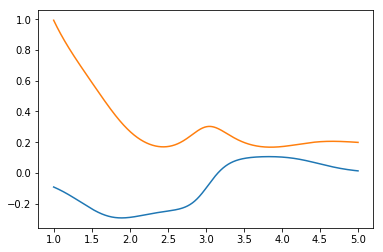

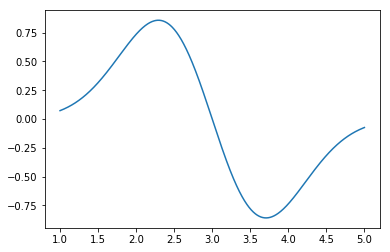

In [11]:
plt.plot(s, np.imag(sigma_1))
plt.plot(s, np.real(sigma_1))
plt.show()
plt.plot(s, dh_ds)
plt.show()

In [51]:
@njit
def M(s, ds, sigma_1, sigma_2):
    col = np.zeros(3*len(s)-4)
    row = np.zeros(3*len(s)-4)
    data = np.zeros(3*len(s)-4)
    data[0] = 2#1
    data[1] = 1#(s[1]-ds/2)/(2*ds**2*s[1])
    row[1] = 1
    col[2:4] = 1
    row[2] = 1
    row[3] = 2
    data[2] = 2#2/ds**2
    data[3] = 1#(s[2]-ds/2)/(2*ds**2*s[2])
    for i in prange(2, len(s)-2):
        col[3*i-2:3*i+1] = i
        row[3*i-2] = i-1
        row[3*i-1] = i
        row[3*i] = i+1
        data[3*i-2] = 3#(s[i-1]+ds/2)/(2*ds**2*s[i-1])
        data[3*i-1] = 2#2/ds**2
        data[3*i] = 1#(s[i+1]-ds/2)/(2*ds**2*s[i+1])
    col[-4:-2] = len(s)-2
    row[-4] = len(s)-3
    row[-3] = len(s)-2
    data[-4] = 3#(s[-3]+ds/2)/(2*ds**2*s[-3])
    data[-3] = 2#2/ds**2
    col[-2:] = len(s)-1
    row[-2] = len(s)-2
    row[-1] = len(s)-1
    data[-2] = 3#(s[-2]+ds/2)/(2*ds**2*s[-2])
    data[-1] = 2#1
    return data, col, row

In [52]:
data, col, row = M(s, ds, sigma_1, sigma_2)
csc_matrix((data, (row, col)), shape=(len(s), len(s))).toarray()
print(col)
print(row)

array([[2., 0., 0., 0., 0.],
       [1., 2., 3., 0., 0.],
       [0., 1., 2., 3., 0.],
       [0., 0., 1., 2., 3.],
       [0., 0., 0., 0., 2.]])

In [59]:
@njit
def M(s, ds, sigma_1, sigma_2):
    col = np.zeros(3*len(s)-4)
    row = np.zeros(3*len(s)-4)
    data = np.zeros(3*len(s)-4)
    data[0] = 1
    data[1] = (s[1]-ds/2)/(2*ds**2*s[1])
    row[1] = 1
    col[2:4] = 1
    row[2] = 1
    row[3] = 2
    data[2] = 2/ds**2
    data[3] = (s[2]-ds/2)/(2*ds**2*s[2])
    for i in prange(2, len(s)-2):
        col[3*i-2:3*i+1] = i
        row[3*i-2] = i-1
        row[3*i-1] = i
        row[3*i] = i+1
        data[3*i-2] = (s[i-1]+ds/2)/(2*ds**2*s[i-1])
        data[3*i-1] = 2/ds**2
        data[3*i] = (s[i+1]-ds/2)/(2*ds**2*s[i+1])
    col[-4:-2] = len(s)-2
    row[-4] = len(s)-3
    row[-3] = len(s)-2
    data[-4] = (s[-3]+ds/2)/(2*ds**2*s[-3])
    data[-3] = 2/ds**2
    col[-2:] = len(s)-1
    row[-2] = len(s)-2
    row[-1] = len(s)-1
    data[-2] = (s[-2]+ds/2)/(2*ds**2*s[-2])
    data[-1] = 1
    return data, col, row

In [62]:
data, col, row = M(s, ds, sigma_1, sigma_2)
A = csc_matrix((data, (col, row)), shape=(len(s), len(s)))
del data, col, row 
lu = sla.splu(A)

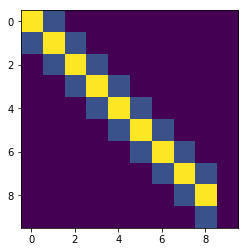

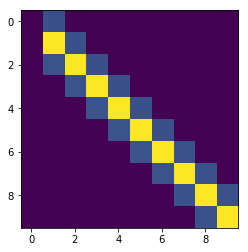

1.0 1.0
1250.0 306.71296296296293


In [68]:
A_array = A.toarray()
plt.imshow(A_array[-10:, -10:])
plt.show()

plt.imshow(A_array[:10, :10])
plt.show()
print(A_array[0, 0], A_array[-1, -1])
print(A_array[1, 1], A_array[1, 2])

In [56]:
f = np.zeros(len(s))
f[0] = 10
f[-1] = -20
phi = lu.solve(f)

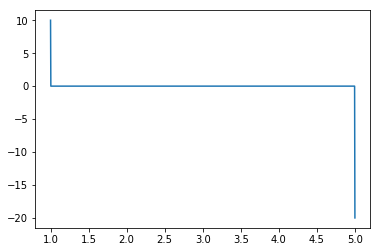

In [57]:
plt.plot(s, phi)
plt.show()